# Slamming velocity

This tutorial demonstrate how to use Snoopy to exctract impact velocities, from RWE and vertical velocities. In this example RWE and vertical velocities will be reconstructed from HydroStar transfert function. 

In [97]:
import numpy as np
from matplotlib import pyplot as plt
from Snoopy import Spectral as sp
from Snoopy import TimeDomain as td
from Snoopy.Dataset import rec34_SD
from Snoopy.Statistics import LongTermImpactSL , LongTermImpact, LongTermRao, probN

## Input

In [98]:
# Position of the impact point, from the mean surface. If pos_z < 0, the point is wetted at rest. 
pos_z = -4.   

# RWE Rao, from HydroStar
rwe_rao = sp.Rao( f"{sp.TEST_DATA:}/rao/RWE_175m.rao" ).getSymmetrized()

# Sea-State description
hs = 5.0
tp = 10.0
gamma = 1.5
heading = np.pi
ss = sp.SeaState( sp.Jonswap( hs , tp , gamma , heading  ) )

**Derivate position to get velocity**

In [99]:
vz_rao = rwe_rao.getDerivate()

**Plot RAOs of RWE and relative velocity**

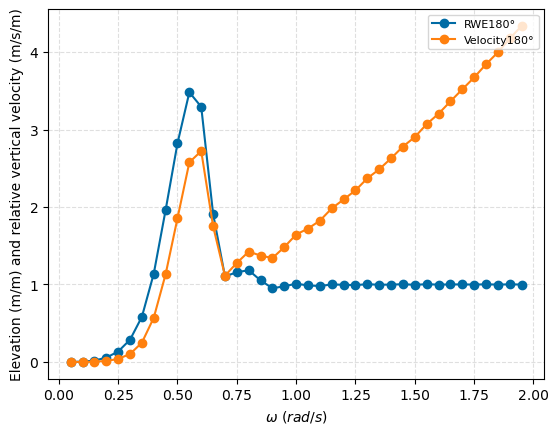

In [100]:
fig, ax = plt.subplots()
rwe_rao.plot( headingsDeg = [180.], ax=ax, label_prefix = "RWE")
vz_rao.plot( headingsDeg = [180.], ax=ax, label_prefix = "Velocity" )
ax.set(ylabel = "Elevation (m/m) and relative vertical velocity (m/s/m)" );

## Time domain approach

**Discretize seastate**

In [101]:
wif = sp.Wif( ss )

**Generate time traces**

In [102]:
rwe_rec = td.ReconstructionRaoLocal(wif , rwe_rao.getSorted(duplicatesBounds = True))
vz_rec = td.ReconstructionRaoLocal(wif , vz_rao.getSorted(duplicatesBounds = True))

In [103]:
simulation_duration = 30 * 3600
time = np.arange( 0. , simulation_duration , 0.25 )
rwe_ts = rwe_rec.evalSe(time)
vz_ts = vz_rec.evalSe(time)

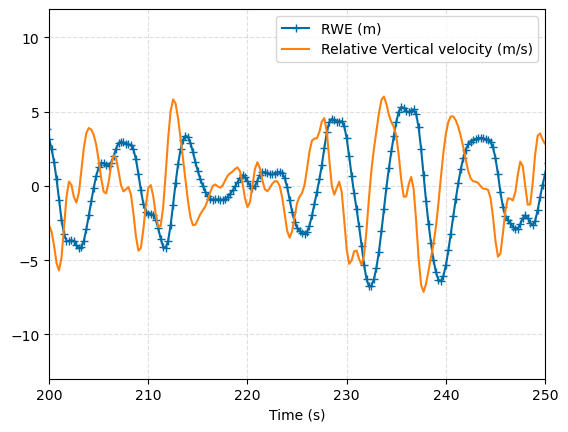

In [104]:
fig , ax = plt.subplots()
ax.plot( time , rwe_ts.values, marker = "+", label = "RWE (m)")
vz_ts.plot(ax=ax, label = "Relative Vertical velocity (m/s)")
ax.set( xlim = [200,250] , xlabel = "Time (s)" )
ax.legend();

**Post-process time series to get impact velocity**

In [105]:
impact = td.getSlammingVelocity( rwe_ts , pos_z = pos_z )

**Plot RWE together with impact velocities**

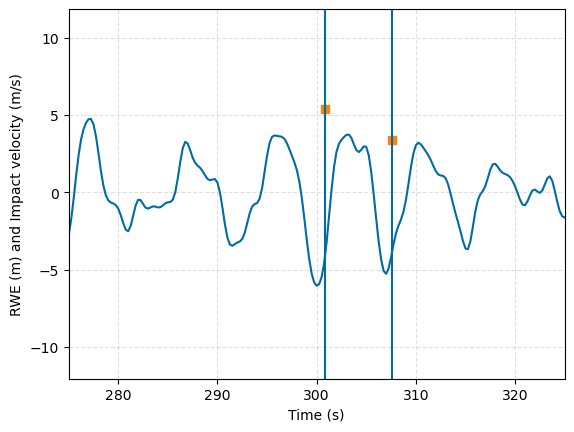

In [106]:
fig , ax = plt.subplots()
ax.plot( time , rwe_ts.values, label = "RWE")
ax.plot( impact.index , impact.values, marker = "s", linestyle = "", label = "Impact velocity")
for i in impact.index.values:
    ax.axvline(i)
ax.set_xlim( [275,325] )
ax.set_xlabel("Time (s)")
ax.set_ylabel("RWE (m) and Impact velocity (m/s)");

**Plot distribution of impact velocities**

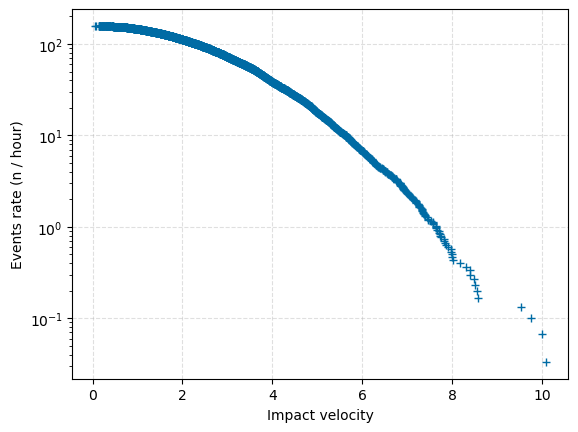

In [107]:
fig, ax = plt.subplots()
# probN provide the empirical exceedance probability of the sorted data.
ax.plot( np.sort( impact.values ) , probN(len(impact)) * len(impact) * 3600 / simulation_duration , "+" )
ax.set_yscale("log")
ax.set_xlabel("Impact velocity")
ax.set_ylabel("Events rate (n / hour)");

## Spectral approach

Results from time domain can be approximated through spectral analysis

In [108]:
rSpec = sp.SpectralMoments( [ss]  , rwe_rao, computeM4 = True )

**Define statistics of motion and velocities**

In [109]:
m_stat = sp.SpectralStats( m0=rSpec.getM0s()[0,0] , m2=rSpec.getM2s()[0,0] )
v_stat = sp.SpectralStats( m0=rSpec.getM2s()[0,0] , m2=rSpec.getM4s()[0,0] )

In [110]:
print (m_stat)

Significant amplitude : 5.07
Up-crossing period : 6.61
3 hours values : 9.73



**Impact probabilities are calculated combining point emergence (or submergence) probability and velocity probability**

Velocity and emergence probabilty are calculated using Rayleigh distribution (which assumes narrow-banded spectrum)

In [111]:
v_impact = np.arange(1. , 10 , 0.5)
velocity_sf = 1 - v_stat.rayleigh.cdf( v_impact ) # Velocity exceedance probability
p_slam = m_stat.rayleigh.sf( abs(pos_z) ) *  v_stat.rayleigh.sf( v_impact )
slam_per_hour = p_slam * 3600 / m_stat.Rtz

Text(0, 0.5, 'Number of impact per hour')

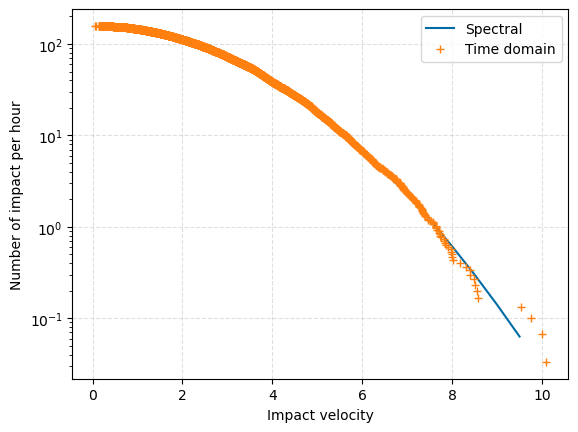

In [112]:
fig, ax = plt.subplots()
ax.plot( v_impact, slam_per_hour , label = "Spectral" )
ax.plot( np.sort( impact.values ) , probN(len(impact))  * 3600 / (simulation_duration / len(impact)) , "+", label = "Time domain" )
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Impact velocity")
ax.set_ylabel("Number of impact per hour")

Agreement between spectral and time domain analysis is reasonable. The spectral post-processing have extra assumption (narrow banded spectrum). Besides, impact/emergence are combined on each cycle, and not instantatenously.

## Long term

The spectral approach can be used to efficiently calculate long-term impact velocities. This is implemented in the **LongTermImpact** class.

In [113]:
ssList = rec34_SD.to_seastate_list( headingList = 12, gamma  = 1.5 , spreadingType=sp.SpreadingType.No, spreadingValue=3.0)

lt_v = LongTermRao( rao = rwe_rao,ssList = ssList, dss = 10800. )
lt_vslam = LongTermImpact( rwe_rao = rwe_rao, ssList = ssList, z = 10.0 , dss = 10800. )


Computes 25 years impact velocity:

In [114]:
print (lt_v.rp_to_x( 25.0 ))
print (lt_vslam.rp_to_x( 25.0 ))

INFO    -       - Running short-term calculation  
INFO    -       - Running short-term calculation  


[29.564389976018923]
[21.9345140192946]


In [115]:
lt_v.longTermSingle().rp_to_x( 100.0 )

32.26831746790856

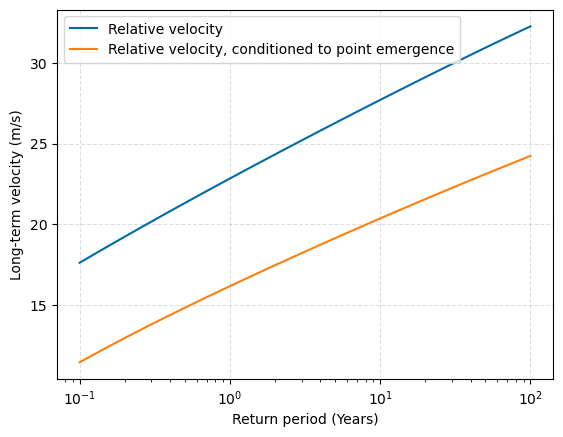

In [116]:
fig, ax = plt.subplots()
lt_v.longTermSingle().plot_rp(rp_range = np.linspace(0.1,100,100), ax=ax, label = "Relative velocity")
lt_vslam.longTermSingle().plot_rp(rp_range =  np.linspace(0.1,100,100) , ax=ax, label = "Relative velocity, conditioned to point emergence")
ax.set(ylabel="Long-term velocity (m/s)")
ax.legend(loc = "upper left");

Compute number of exceedance of a critical velocity, on each sea-state, in a given duration :

In [117]:
n_e = lt_vslam.longTermSingle().nExceed( 10.0 , duration = 1 )
print (f"10m/s is exceeded {np.sum(n_e):.1f} times in 1 year")


10m/s is exceeded 107.9 times in 1 year


For case, were there is linearization of quadratic damping to be performed, the **LongTermImpactSL** class can be used

In [118]:
roll_rao = sp.Rao( f"{sp.TEST_DATA:}/rao/Impact_vel_Roll.rao" ) * np.pi / 180.
rwe_rao_sl = sp.Rao( f"{sp.TEST_DATA:}/rao/Impact_vel_RWE.rao" )

lt_vslam_sl = LongTermImpactSL( ssList, rao_sl = roll_rao , rwe_rao = rwe_rao_sl , z = 1.088 , bLin = 15548000.0, bQuad = 194570000.0  )

In [119]:
lt_vslam_sl.rp_to_x( 25.0 )


INFO    -       - Running short-term calculation  


[26.81804998452491]